In [ ]:
pip install spotipy # spotipy is a python library that allows us to access the spotify

In [ ]:
pip install tekore # for the python file we're importing as a library

In [ ]:
from fastai.collab import * # conda install -c fastchan fastai
from fastai.tabular import *
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2

In [ ]:
CLIENT_ID = "c09718dc490d41e0882379835a5361ed"
CLIENT_SECRET = "6413ff2405754a86897f5db62d475b41"
username = "Mick Leda"
market = [ "AD", "AR", "AT", "AU", "BE", "BG", "BO", "BR", "CA", "CH", "CL", "CO", "CR", "CY", 
      "CZ", "DE", "DK", "DO", "EC", "EE", "ES", "FI", "FR", "GB", "GR", "GT", "HK", "HN", "HU", 
      "ID", "IE", "IS", "IT", "JP", "LI", "LT", "LU", "LV", "MC", "MT", "MX", "MY", "NI", "NL", 
      "NO", "NZ", "PA", "PE", "PH", "PL", "PT", "PY", "SE", "SG", "SK", "SV", "TH", "TR", "TW", 
      "US", "UY", "VN" ]
redirect_uri='http://localhost:8888/callback/'

In [ ]:
# credentials to access spotify api
credentials = oauth2.SpotifyClientCredentials(
        client_id="c09718dc490d41e0882379835a5361ed",
        client_secret="6413ff2405754a86897f5db62d475b41")

token = credentials.get_access_token()
sp = spotipy.Spotify(auth=token)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  


In [ ]:
client_id="c09718dc490d41e0882379835a5361ed"
client_secret="6413ff2405754a86897f5db62d475b41"
username = "Mick Leda"

# extended the scope to also modify non-public playlists
scope = "playlist-modify-public playlist-modify-private playlist-read-private playlist-read-collaborative" # gives us the access to do these things

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, 
                                                      client_secret=client_secret)
                                                      
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
##################################################################################
## ONLY RUN IF YOU NEED A NEW DATABASE, OTHERWISE, USE VALENCE_AROUSAL_DATA.CSV ##
###################################################################################

# Import modules
import sys
# If your authentification script is not in the project directory
# append its folder to sys.path
sys.path.append("../spotify_api_web_app")
import authorization
import pandas as pd
from tqdm import tqdm
import time

# Authorize and call access object "sp"
sp = authorization.authorize()

# Get all genres
genres = sp.recommendation_genre_seeds()

# Set number of df per genre
n_recs = 10

# Initiate a dictionary with all the information you want to crawl
data_dict = {"id":[], "genre":[], "track_name":[], "artist_name":[],
             "valence":[], "energy":[], "danceability":[], "loudness":[], "mode":[], "tempo":[]} 

################
## CRAWL DATA ##
################

# Get recs for every genre
for g in tqdm(genres):
    
    # Get n df
    recs = sp.df(genres = [g], limit = n_recs)
    # json-like string to dict
    recs = eval(recs.json().replace("null", "-999").replace("false", "False").replace("true", "True"))["tracks"]
    
    # Crawl data from each track
    for track in recs:
        # ID and Genre
        data_dict["id"].append(track["id"])
        data_dict["genre"].append(g)
        # Metadata
        track_meta = sp.track(track["id"])
        data_dict["track_name"].append(track_meta.name)
        data_dict["artist_name"].append(track_meta.album.artists[0].name)
        # Audio features
        track_features = sp.track_audio_features(track["id"])
        data_dict["valence"].append(track_features.valence)
        data_dict["energy"].append(track_features.energy)
        data_dict["danceability"].append(track_features.danceability)
        data_dict["loudness"].append(track_features.loudness)
        data_dict["mode"].append(track_features.mode)
        data_dict["tempo"].append(track_features.tempo)
      
        
        # Wait 0.5 seconds per track so that the api doesnt overheat
        time.sleep(1.2)
        
##################
## PROCESS DATA ##
##################

# Store data in dataframe
df = pd.DataFrame(data_dict)

# Drop duplicates
df.drop_duplicates(subset = "id", keep = "first", inplace = True)
df.to_csv("valence_arousal_dataset.csv", index = False)
    
# export to json if successful https://www.statology.org/pandas-to-csv/

100%|██████████| 126/126 [29:14<00:00, 13.92s/it]


In [ ]:
df.to_json(r'C:\Users\micha\itmgt\recs.json', index=True)

In [ ]:
import pandas as pd
import random
import authorization # this is the script we created earlier
import numpy as np
from numpy.linalg import norm

In [ ]:
df = pd.read_csv("valence_arousal_dataset.csv")

In [ ]:
df["mood_vec"] = df[["valence", "energy"]].values.tolist()

In [ ]:
sp = authorization.authorize()

In [ ]:
def recommend(track_id, ref_df, sp, n_recs = 5):
    
    # Crawl valence and arousal of given track from spotify api
    track_features = sp.track_audio_features(track_id)
    track_moodvec = np.array([track_features.valence, track_features.energy])
    
    # Compute distances to all reference tracks
    ref_df["distances"] = ref_df["mood_vec"].apply(lambda x: norm(track_moodvec-np.array(x)))
    # Sort distances from lowest to highest
    ref_df_sorted = ref_df.sort_values(by = "distances", ascending = True)
    # If the input track is in the reference set, it will have a distance of 0, but should not be recommendet
    ref_df_sorted = ref_df_sorted[ref_df_sorted["id"] != track_id]


    # Return n df
    return ref_df_sorted.iloc[:n_recs]

In [ ]:
# getting df
import re
# paste spotify song link
spotify_link = "https://open.spotify.com/track/4q8f3Ls32PcXE8Ks4V1ufx?si=ccfd79e986e6427b" # Chopin “Raindrop Prelude” Op.28 No.15
spotify_id = re.search(r"\w{22}", spotify_link).group() # spotify track ids are always 22 characters long

recommendations = recommend(track_id = spotify_id, ref_df = df, sp = sp, n_recs = 10)

recommend(track_id = spotify_id, ref_df = df, sp = sp, n_recs = 10)

,id,genre,track_name,artist_name,valence,energy,danceability,loudness,mode,tempo,mood_vec,distances
175,1QmhkjuUlosROqKk59sBSK,classical,Opening,Bruce Brubaker,0.0680,0.0260,0.1790,-30.937,0,77.116,"[0.068, 0.026]",0.026191
803,1a8q5IaLsLfDXqzqDD2NAv,opera,"Turandot (2008 Digital Remaster), Act I: La, sui monti dell'est",Giacomo Puccini,0.1170,0.0230,0.2320,-31.144,1,125.241,"[0.117, 0.023]",0.041742
841,2SfGBvTAQZ5SV35ITj9NJg,piano,Two Trees,Ludovico Einaudi,0.0428,0.0217,0.2570,-28.628,1,83.828,"[0.0428, 0.0217]",0.042025
761,4hPFuA3y7EA4hdmnSNuK5A,movies,The Chalice Passed,Various Artists,0.0374,0.0100,0.2480,-32.183,1,77.047,"[0.0374, 0.01]",0.043577
179,24A3HjyT5sGnrejr7yLDod,classical,"Nocturne in E-Flat Major, Op. 9, No.2",Frédéric Chopin,0.0710,0.0462,0.3930,-25.575,1,136.880,"[0.071, 0.0462]",0.044279
272,3wQO1I7Yov2RrRDjBpxJ82,disney,"River's Edge - From ""Pocahontas""/Score",Various Artists,0.0601,0.0462,0.1750,-27.430,1,119.430,"[0.0601, 0.0462]",0.047795
1111,6zln8XF6yTVmLXVED5KgRm,soundtracks,The Emperor Is Dead,The Lyndhurst Orchestra,0.0307,0.0118,0.2370,-34.379,1,109.537,"[0.0307, 0.0118]",0.050485
174,6nywzGnK18ZkKoQ5DY7aD5,classical,"Suite No. 1, Op. 13: III. Nocturne",Jules Massenet,0.0353,0.0296,0.0906,-26.753,1,85.443,"[0.0353, 0.0296]",0.052396
662,3oSBVpyGQ9N3hPibpw0GkB,jazz,Peace Piece,Bill Evans,0.0652,0.0571,0.4600,-17.307,1,114.574,"[0.0652, 0.0571]",0.056262
787,6fsKpHpWbAGbE6Sbvy7wZ7,new-age,Girl From Barcelona,Various Artists,0.0464,0.0501,0.3120,-26.610,0,118.299,"[0.0464, 0.0501]",0.058146


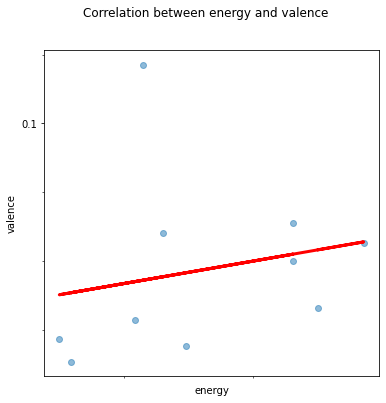

In [ ]:
# data visualization
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

%matplotlib inline

# correlation between the energy and valence of the recommended songs
x = recommendations["energy"].values
y = recommendations["valence"].values

x = x.reshape(x.shape[0], 1)
y = y.reshape(y.shape[0], 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

fig = plt.figure(figsize=(6, 6))
fig.suptitle("Correlation between energy and valence")

ax = plt.subplot(1, 1, 1)
ax.scatter(x, y, alpha=0.5)
ax.plot(x, regr.predict(x), color="red", linewidth=3)
plt.xticks(())
plt.yticks(())

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

plt.xlabel("energy")
plt.ylabel("valence")

plt.show()

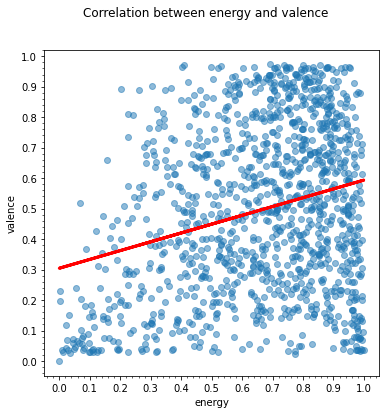

In [ ]:
# correlation between the energy and valence of the current entire song database
x = df["energy"].values
y = df["valence"].values

x = x.reshape(x.shape[0], 1)
y = y.reshape(y.shape[0], 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

fig = plt.figure(figsize=(6, 6))
fig.suptitle("Correlation between energy and valence")

ax = plt.subplot(1, 1, 1)
ax.scatter(x, y, alpha=0.5)
ax.plot(x, regr.predict(x), color="red", linewidth=3)
plt.xticks(())
plt.yticks(())

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

plt.xlabel("energy")
plt.ylabel("valence")

plt.show()

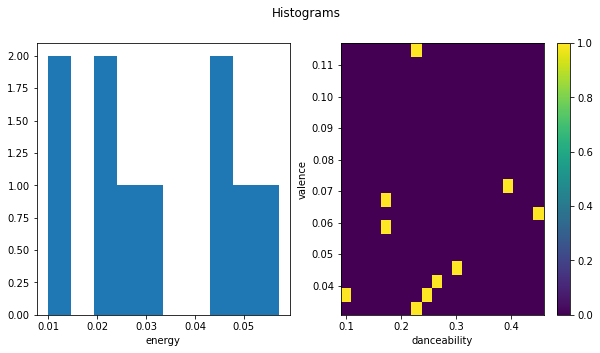

In [ ]:
# Now to create some histograms
# The plot on the left illustrates the distribution of songs based on their energy levels
# whereas the one on the right is a heatmap that illustrates the number of songs found at all values of valence and danceability.

x = "danceability"
y = "valence"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(10, 5))
fig.suptitle("Histograms")
h = ax2.hist2d(recommendations[x], recommendations[y], bins=20)
ax1.hist(recommendations["energy"])

ax2.set_xlabel(x)
ax2.set_ylabel(y)

ax1.set_xlabel("energy")

plt.colorbar(h[3], ax=ax2)

plt.show()

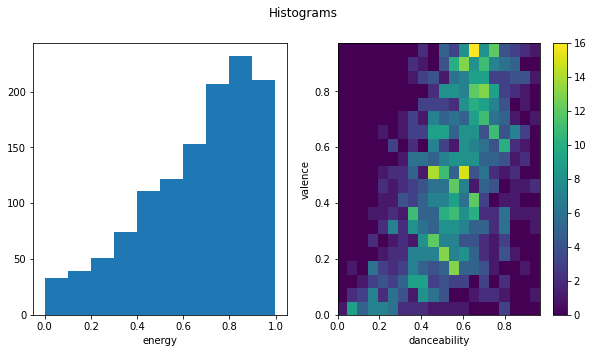

In [ ]:
# Now to create some histograms
# The plot on the left illustrates the distribution of songs based on their energy levels
# whereas the one on the right is a heatmap that illustrates the number of songs found at all values of valence and danceability.

x = "danceability"
y = "valence"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(10, 5))
fig.suptitle("Histograms")
h = ax2.hist2d(df[x], df[y], bins=20)
ax1.hist(df["energy"])

ax2.set_xlabel(x)
ax2.set_ylabel(y)

ax1.set_xlabel("energy")

plt.colorbar(h[3], ax=ax2)

plt.show()

In [ ]:
chosen = ["energy", "tempo", "valence", "loudness", "mode", "danceability"]
text1 = df["artist_name"] + " - " + df["track_name"]
text2 = text1.values

# X = df.drop(droppable, axis=1).values
X = df[chosen].values
y = df["valence"].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

pca = PCA(n_components=3)
pca.fit(X)

X = pca.transform(X)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

trace = go.Scatter3d(
    x=X[:,0],
    y=X[:,1],
    z=X[:,2],
    text=text2,
    mode="markers",
    marker=dict(
        size=8,
        color=y
    )
)

fig = go.Figure(data=[trace])
py.iplot(fig, filename="test-graph")

In [ ]:
chosen = ["energy", "danceability", "tempo", "valence"]
text1 = df["artist_name"] + " - " + df["track_name"]
text2 = text1.values

# X = df.drop(droppable, axis=1).values
X = df[chosen].values
y = df["valence"].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X)

X = pca.transform(X)

fig = {
    "data": [
        {
            "x": X[:, 0],
            "y": X[:, 1],
            "text": text2,
            "mode": "markers",
            "marker": {"size": "8", "color": y}
        }
    ],
    "layout": {
        "xaxis": {"title": "How hard is this to dance to?"},
        "yaxis": {"title": "How metal is this?"}
    }
}

py.iplot(fig, filename="test-graph2")